In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import math
import numpy as np
import os
import random as rnd

In [2]:
dfChips = pd.read_csv('chips.csv')
chipsTarget = dfChips['class']

dfGeyser = pd.read_csv('geyser.csv')
geyserTarget = dfGeyser['class']

In [3]:
XChips = dfChips[['x', 'y']]
yChips = dfChips['class']

In [4]:
XGeyser = dfGeyser[['x', 'y']]
yGeyser = dfGeyser['class']

In [5]:
Y = []
for val in yChips:
    if(val == 'N'):
        Y.append(-1)
    else:
        Y.append(1)
        
X = XChips.values.tolist()

X, Y = shuffle(X, Y)

In [6]:
def splitByBlock(X, Y, block, i):
    x_train = X[0:(i*block)] + X[(i*block) + block:]
    y_train = Y[0:(i*block)] + Y[(i*block) + block:]
    x_test = X[(i*block): (i*block) + block]
    y_test = Y[(i*block): (i*block) + block]
    return x_train, y_train, x_test, y_test

In [33]:
def printDots(x, y, bg_x, bg_y):
    n = len(x)
    m = len(bg_x)
    
    P_x1 = [x[i][0] for i in range(n) if y[i] >= 0]
    P_x2 = [x[i][1] for i in range(n) if y[i] >= 0]
            
    N_x1 = [x[i][0] for i in range(n) if y[i] < 0]
    N_x2 = [x[i][1] for i in range(n) if y[i] < 0]
    
    P_b1 = [bg_x[i][0] for i in range(m) if bg_y[i] >= 0]
    P_b2 = [bg_x[i][1] for i in range(m) if bg_y[i] >= 0]
            
    N_b1 = [bg_x[i][0] for i in range(m) if bg_y[i] < 0]
    N_b2 = [bg_x[i][1] for i in range(m) if bg_y[i] < 0]
    
    plt.scatter(P_x1, P_x2, marker='+', color='green')
    plt.scatter(N_x1, N_x2, marker='_', color='red')
    plt.scatter(P_b1, P_b2, marker='.', color='green', alpha = 0.2)
    plt.scatter(N_b1, N_b2, marker='.', color='red', alpha = 0.2)

In [46]:
class perfectSVM():
    def __init__(self, max_iter=1000, kernel_type='linear', C=1.0, epsilon=0.0001, param=1):
        self.kernels = {
            'linear' : self.kernel_linear,
            'poly' : self.kernel_poly,
            'gauss' : self.kernel_gauss
        }
        self.max_iter = max_iter
        self.kernel_type = kernel_type
        self.C = C
        self.epsilon = epsilon
        self.param = param
        
    def fit(self, X, y):
        n, d = X.shape[0], X.shape[1]
        C = self.C
        alpha = np.zeros((n)) #lagrange multipliers
        b = 0 # threshold for solution
        
        kernel = self.kernels[self.kernel_type]
        for step in range(self.max_iter):
            for i in range(n):
                j = self.get_rnd_int(0, n-1, i)
                
                ai = alpha[i] # save old
                aj = alpha[j] # save old
                
                Ei = self.f(X, y, X[i], b, alpha, kernel) - y[i]
                Ej = self.f(X, y, X[j], b, alpha, kernel) - y[j]
                
                L = max(0, alpha[j] - alpha[i]) if y[i] != y[j] else max(0, alpha[i] + alpha[j] - C)
                H = min(C, C + alpha[j] - alpha[i]) if y[i] != y[j] else min(C, alpha[i] + alpha[j])
                if L == H:
                    continue
                
                nj = 2 * kernel(X[i], X[j]) - kernel(X[i], X[i]) - kernel(X[j], X[j])
                if nj >= 0:
                    continue
                
                alpha[j] = alpha[j] - y[j] * (Ei - Ej) / nj
                alpha[j] = min(alpha[j], H)
                alpha[j] = max(alpha[j], L)
                if abs(alpha[j] - aj) < self.epsilon:
                    break
                
                alpha[i] = alpha[i] + y[i] * y[j] * (aj - alpha[j]) 
                b1 = b - Ei - y[i] * (alpha[i] - ai) * kernel(X[i], X[i]) - y[j] * (alpha[j] - aj) * kernel(X[i], X[j])
                b2 = b - Ej - y[i] * (alpha[i] - ai) * kernel(X[i], X[j]) - y[j] * (alpha[j] - aj) * kernel(X[j], X[j])
                b = b1 if 0 < alpha[i] and alpha[i] < C else (b2 if 0 < alpha[j] and alpha[j] < C else (b1 + b2) / 2)
        self.X = X
        self.y = y
        self.alpha = alpha
        self.b = b
        return (X, y, alpha, b)
    
    def toClass(self, arg):
        return 1 if arg >= 0 else -1
    
    def f(self, X, y, x, b, alpha, kernel):
        return sum([alpha[i] * y[i] * kernel(X[i], x) for i in range(len(X))]) + b
    
    def predict(self, X) :
        kernel = self.kernels[self.kernel_type]
        return [self.toClass(self.f(self.X, self.y, point, self.b, self.alpha, kernel)) for point in X]

    def predict_e(self, Xs, ys, X, alphas, bs) :
        kernel = self.kernels[self.kernel_type]
        return [self.toClass(self.f(Xs, ys, point, bs, alphas, kernel)) for point in X]
    
    def get_rnd_int(self, a,b,z):
        i = z
        cnt=0
        while i == z and cnt<1000:
            i = rnd.randint(a,b)
            cnt=cnt+1
        return i   
        
    def kernel_linear(self, x1, x2):
        return sum([x * y for (x, y) in zip(x1, x2)])
        #return np.dot(x1, x2.T)
    def kernel_poly(self, x1, x2):
        return sum([(x * y) ** self.param for (x, y) in zip(x1, x2)])
        #return (np.dot(x1, x2.T) ** self.param)
    def kernel_gauss(self, x1, x2):
        summ = sum([(x - y) ** 2 for (x, y) in zip(x1, x2)])
        gam = self.param
        
        return math.exp((-gam)*summ)

In [43]:
def svm_function(X, Y, kernel, param):
    X, Y = shuffle(X, Y)
    iterations = 7
    block = len(X) // iterations
    max_score = 0
    #w = np.zeros((len(X[0])))
    #b = 0
    perfect_set = () # (X, y, alpha, b)
    for i in range(iterations):
        x_train, y_train, x_test, y_test = splitByBlock(X, Y, block, i)
        
        x_train = np.array(x_train)
        y_train = np.array(y_train)
        x_test = np.array(x_test)
        y_test = np.array(y_test)
        
        model = perfectSVM(max_iter=2000, kernel_type=kernel, param=param)
        some_set = model.fit(x_train, y_train)
        #print("alpha ", some_set[2])
        #print("b ", some_set[3])
        prediction = model.predict(x_test)
      
        temp_score = accuracy_score(y_test, np.array(prediction))
        if temp_score > max_score:
            max_score = temp_score
            perfect_set = some_set
        
    X, Y = np.array(X), np.array(Y)
    X, Y = shuffle(X, Y)
    model = perfectSVM(max_iter=1000, kernel_type=kernel, C=1, epsilon=0.01, param=param)
    #prediction = model.predict_w_b(w, b, X)
    #model.fit(X, Y)
    #prediction = model.predict(X)
    prediction = model.predict_e(perfect_set[0], perfect_set[1], X, perfect_set[2], perfect_set[3]) # (X, y, alpha, b)
    #printDots(X, Y)
    plt.show()
    
    min_x1 = min([X[i][0] for i in range(len(X))])
    max_x1 = max([X[i][0] for i in range(len(X))])
    x1_range = max_x1 - min_x1
    min_x2 = min([X[i][1] for i in range(len(X))])
    max_x2 = max([X[i][1] for i in range(len(X))])
    x2_range = max_x2 - min_x2
    bg_X = [[min_x1 + i*(x1_range/100), min_x2 + j*(x2_range/100)] for j in range(1, 100) for i in range(1, 100)]
    bg_Y = model.predict_e(perfect_set[0], perfect_set[1], bg_X, perfect_set[2], perfect_set[3])
    printDots(X, Y, bg_X, bg_Y)
    plt.show()
    #print(prediction)
    print("score: ", accuracy_score(Y, prediction))      

## Первый датасет

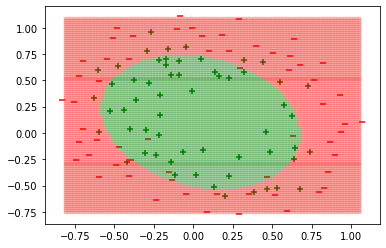

score:  0.7711864406779662


In [39]:
svm_function(X, Y, "gauss", 0.3)

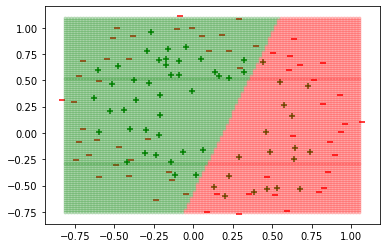

score:  0.5508474576271186


In [47]:
svm_function(X, Y, "linear", 0)

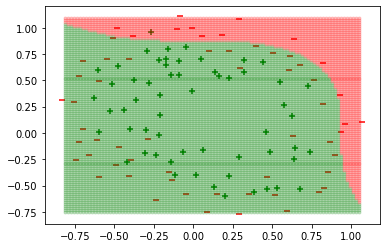

score:  0.6016949152542372


In [48]:
svm_function(X, Y, "poly", 3)

## Второй датасет

In [49]:
YGeyser2 = []
for val in yGeyser:
    if(val == 'N'):
        YGeyser2.append(-1)
    else:
        YGeyser2.append(1)
        
XGeyser2 = XGeyser.values.tolist()

XGeyser2, YGeyser2 = shuffle(XGeyser2, YGeyser2)

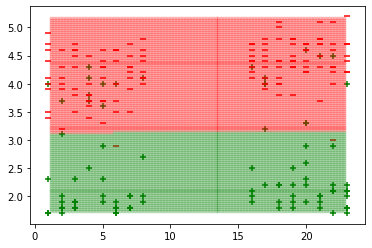

score:  0.8963963963963963


In [50]:
svm_function(XGeyser2, YGeyser2, "linear", 0)

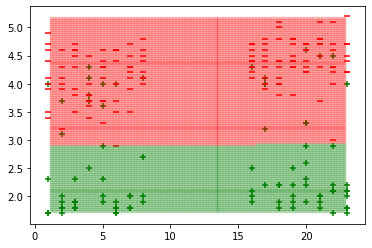

score:  0.8963963963963963


In [51]:
svm_function(XGeyser2, YGeyser2, "poly", 2)

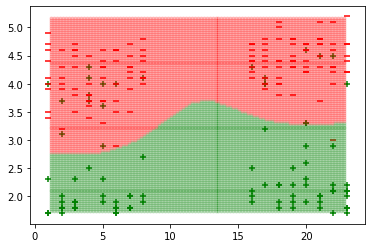

score:  0.8963963963963963


In [52]:
svm_function(XGeyser2, YGeyser2, "gauss", 0.03)